In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import warnings; warnings.filterwarnings("ignore")
from scipy.stats import mannwhitneyu, normaltest
from sklearn.manifold import SpectralEmbedding
from sklearn.metrics.pairwise import euclidean_distances
from statannotations.Annotator import Annotator
from statannot import add_stat_annotation
import matplotlib.pyplot as plt
import autograd.numpy as np
import seaborn as sns
import pandas as pd
from scipy import optimize
import statannot
import warnings
import dabest
import utils
import umap
#plt.style.use('fivethirtyeight')

In [3]:
RNAseq_url = "https://github.com/riazn/bms038_analysis/blob/master/data/CountData.BMS038.txt"

In [4]:
df_exp = pd.read_csv(RNAseq_url+"?raw=true", header=0, sep="\t", error_bad_lines=False)
df_exp.head()

,Pt101_On,Pt101_Pre,Pt103_On,Pt103_Pre,Pt105_On,Pt106_On,Pt106_Pre,Pt108_On,Pt109_On,Pt109_On.2,...,Pt92_Pre,Pt92_Pre.2,Pt93_On,Pt94_On,Pt94_Pre,Pt98_On,Pt98_Pre,Pt9_On,Pt9_Pre,HUGO
1,251,279,661,1124,201,243,290,352,175,106,...,76,116,244,6387,278,229,278,236,156,A1BG
10,6,0,0,0,0,1,3,2,0,0,...,0,2,0,561,1,0,0,11,9,NAT2
100,2085,1630,136,1069,842,573,800,188,329,300,...,695,828,117,249,523,400,212,398,345,ADA
1000,536,228,3,23,92,2581,3114,618,71,50,...,557,1135,56,1686,161,139,190,6957,4990,CDH2
10000,3156,2485,5644,1337,5520,7594,9432,629,1712,1641,...,5244,6730,8592,2678,4953,6898,5735,8434,7804,AKT3


In [5]:
df = df_exp.set_index('HUGO').transpose()
#df = df.reset_index(level=0)
#df.rename(columns = {"index": "SampleID"}, inplace=True)
#df.rename_axis(None, axis=1, inplace=True)
df.head()

HUGO,A1BG,NAT2,ADA,CDH2,AKT3,ZBTB11-AS1,MED6,NR2E3,NAALAD2,SNORD116-1,...,HNRNPDL,DMTF1,PPP4R1,CDH1,SLC12A6,PTBP3,KCNE2,DGCR2,CASP8AP2,SCO2
Pt101_On,251,6,2085,536,3156,168,1250,3,99,0,...,14425,4769,2293,2372,5923,12483,6,3820,2803,3
Pt101_Pre,279,0,1630,228,2485,74,1191,0,19,0,...,11111,3747,1888,1369,4622,9871,9,3251,2428,12
Pt103_On,661,0,136,3,5644,99,509,6,50,4,...,11695,4537,4090,12683,670,3941,8,7263,842,4
Pt103_Pre,1124,0,1069,23,1337,145,484,0,87,0,...,4870,915,1828,1220,396,1854,0,1706,242,29
Pt105_On,201,0,842,92,5520,128,698,2,19,3,...,13960,1514,2948,22567,1253,5050,88,3727,1202,7


In [6]:
df0 = df.iloc[:, 0:5]; df0.columns.tolist()

['A1BG', 'NAT2', 'ADA', 'CDH2', 'AKT3']

In [7]:
print(df.iloc[0:4,0:4])
X_train = df.values[:,0:(df.shape[1]-1)]
X_train = np.log(X_train + 1)
n = X_train.shape[0]
print("\nThis data set contains " + str(n) + " samples")
y_train = df.values[:,df.shape[1]-1]
print("\nDimensions of the  data set: ")
print(X_train.shape, y_train.shape)

HUGO       A1BG  NAT2   ADA  CDH2
Pt101_On    251     6  2085   536
Pt101_Pre   279     0  1630   228
Pt103_On    661     0   136     3
Pt103_Pre  1124     0  1069    23

This data set contains 118 samples

Dimensions of the  data set: 
(118, 22332) (118,)


In [8]:
dist = np.square(euclidean_distances(X_train, X_train))
rho = [sorted(dist[i])[1] for i in range(dist.shape[0])]
print(dist[0:4, 0:4])
print('\n')
print(rho[0:4])

[[    0.          9439.70348682 51138.66535601 56452.27959287]
 [ 9439.70348682     0.         49283.65107529 50738.24032378]
 [51138.66535601 49283.65107529     0.         31940.35838238]
 [56452.27959287 50738.24032378 31940.35838238     0.        ]]


[9439.703486816492, 9439.703486816492, 22057.595771537864, 31940.35838237859]


In [9]:
# For each row of Euclidean distance matrix (dist_row) compute probability in high dimensions (1D array)
def prob_high_dim(sigma, dist_row):
    d = dist[dist_row] - rho[dist_row]
    d[d < 0] = 0
    return np.exp(- d / sigma)

# Compute n_neighbor = k (scalar) for each 1D array of high-dimensional probability
def k(prob):
    return np.power(2, np.sum(prob))

#     Solve equation k_of_sigma(sigma) = fixed_k with respect to sigma by the binary search algorithm
def sigma_binary_search(k_of_sigma, fixed_k):
    sigma_lower_limit = 0
    sigma_upper_limit = 1000
    for i in range(20):
        approx_sigma = (sigma_lower_limit + sigma_upper_limit) / 2
        if k_of_sigma(approx_sigma) < fixed_k:
            sigma_lower_limit = approx_sigma
        else:
            sigma_upper_limit = approx_sigma
        if np.abs(fixed_k - k_of_sigma(approx_sigma)) <= 1e-5:
            break
    return approx_sigma

In [10]:
N_NEIGHBOR = 15
prob = np.zeros((n,n))
sigma_array = []
for dist_row in range(n):
    func = lambda sigma: k(prob_high_dim(sigma, dist_row))
    binary_search_result = sigma_binary_search(func, N_NEIGHBOR)
    prob[dist_row] = prob_high_dim(binary_search_result, dist_row)
    sigma_array.append(binary_search_result)
    if (dist_row + 1) % 100 == 0:
        print("Sigma binary search finished {0} of {1} cells".format(dist_row + 1, n))
print("\nMean sigma = " + str(round(np.mean(sigma_array),3)))

Sigma binary search finished 100 of 118 cells

Mean sigma = 984.56


In [11]:
#P = prob + np.transpose(prob) - np.multiply(prob, np.transpose(prob))
P = (prob + np.transpose(prob)) / 2

In [12]:
MIN_DIST = 0.25

x = np.linspace(0, 3, 300)

def f(x, min_dist):
    y = []
    for i in range(len(x)):
        if(x[i] <= min_dist):
            y.append(1)
        else:
            y.append(np.exp(- x[i] + min_dist))
    return y

dist_low_dim = lambda x, a, b: 1 / (1 + a*x**(2*b))

p , _ = optimize.curve_fit(dist_low_dim, x, f(x, MIN_DIST))

a = p[0]
b = p[1] 
print("Hyperparameters a = " + str(round(a,3)) + " and b = " + str(round(b,3)))

Hyperparameters a = 1.121 and b = 1.057


In [13]:
a = 1
b = 1

In [14]:
# Compute matrix of probabilities q_ij in low-dimensional space
def prob_low_dim(Y):
    inv_distances = np.power(1 + a * np.square(euclidean_distances(Y, Y))**b, -1)
    return inv_distances
# Compute Cross-Entropy (CE) from matrix of high-dimensional probabilities and coordinates of low-dimensional embeddings
def CE(P, Y):
    Q = prob_low_dim(Y)
    return - P * np.log(Q + 0.01) - (1 - P) * np.log(1 - Q + 0.01)

# Compute the gradient of Cross-Entropy (CE)
def CE_gradient(P, Y):
    y_diff = np.expand_dims(Y, 1) - np.expand_dims(Y, 0)
    inv_dist = np.power(1 + a * np.square(euclidean_distances(Y, Y))**b, -1)
    Q = np.dot(1 - P, np.power(0.001 + np.square(euclidean_distances(Y, Y)), -1))
    np.fill_diagonal(Q, 0)
    Q = Q / np.sum(Q, axis = 1, keepdims = True)
    fact = np.expand_dims(a * P * (1e-8 + np.square(euclidean_distances(Y, Y)))**(b-1) - Q, 2)
    return 2 * b * np.sum(fact * y_diff * np.expand_dims(inv_dist, 2), axis = 1)

In [15]:
N_LOW_DIMS = 2
LEARNING_RATE = 1
MAX_ITER = 50       # 200

np.random.seed(12345)
model = SpectralEmbedding(n_components = N_LOW_DIMS, n_neighbors = 50)
y = model.fit_transform(np.log(X_train + 1))
#y = np.random.normal(loc = 0, scale = 1, size = (n, N_LOW_DIMS))

CE_array = []
print("Running Gradient Descent: \n")
for i in range(MAX_ITER):
    y = y - LEARNING_RATE * CE_gradient(P, y)
    
    plt.figure(figsize=(20,15))
    plt.scatter(y[:,0], y[:,1], c = y_train.astype(int), cmap = 'tab10', s = 50)
    plt.title("UMAP on Cancer Associated Fibroblasts (CAFs): Programmed from Scratch", fontsize = 20)
    plt.xlabel("UMAP1", fontsize = 20); plt.ylabel("UMAP2", fontsize = 20)
    #plt.savefig('./UMAP_Plots/UMAP_iter_' + str(i) + '.png')
    plt.close()
    
    CE_current = np.sum(CE(P, y)) / 1e+5
    CE_array.append(CE_current)
    if i % 10 == 0:
        print("Cross-Entropy = " + str(round(CE_current,3)) + " after " + str(i) + " iterations")

Running Gradient Descent: 

Cross-Entropy = 0.566 after 0 iterations
Cross-Entropy = 0.022 after 10 iterations
Cross-Entropy = 0.012 after 20 iterations
Cross-Entropy = 0.01 after 30 iterations
Cross-Entropy = 0.009 after 40 iterations


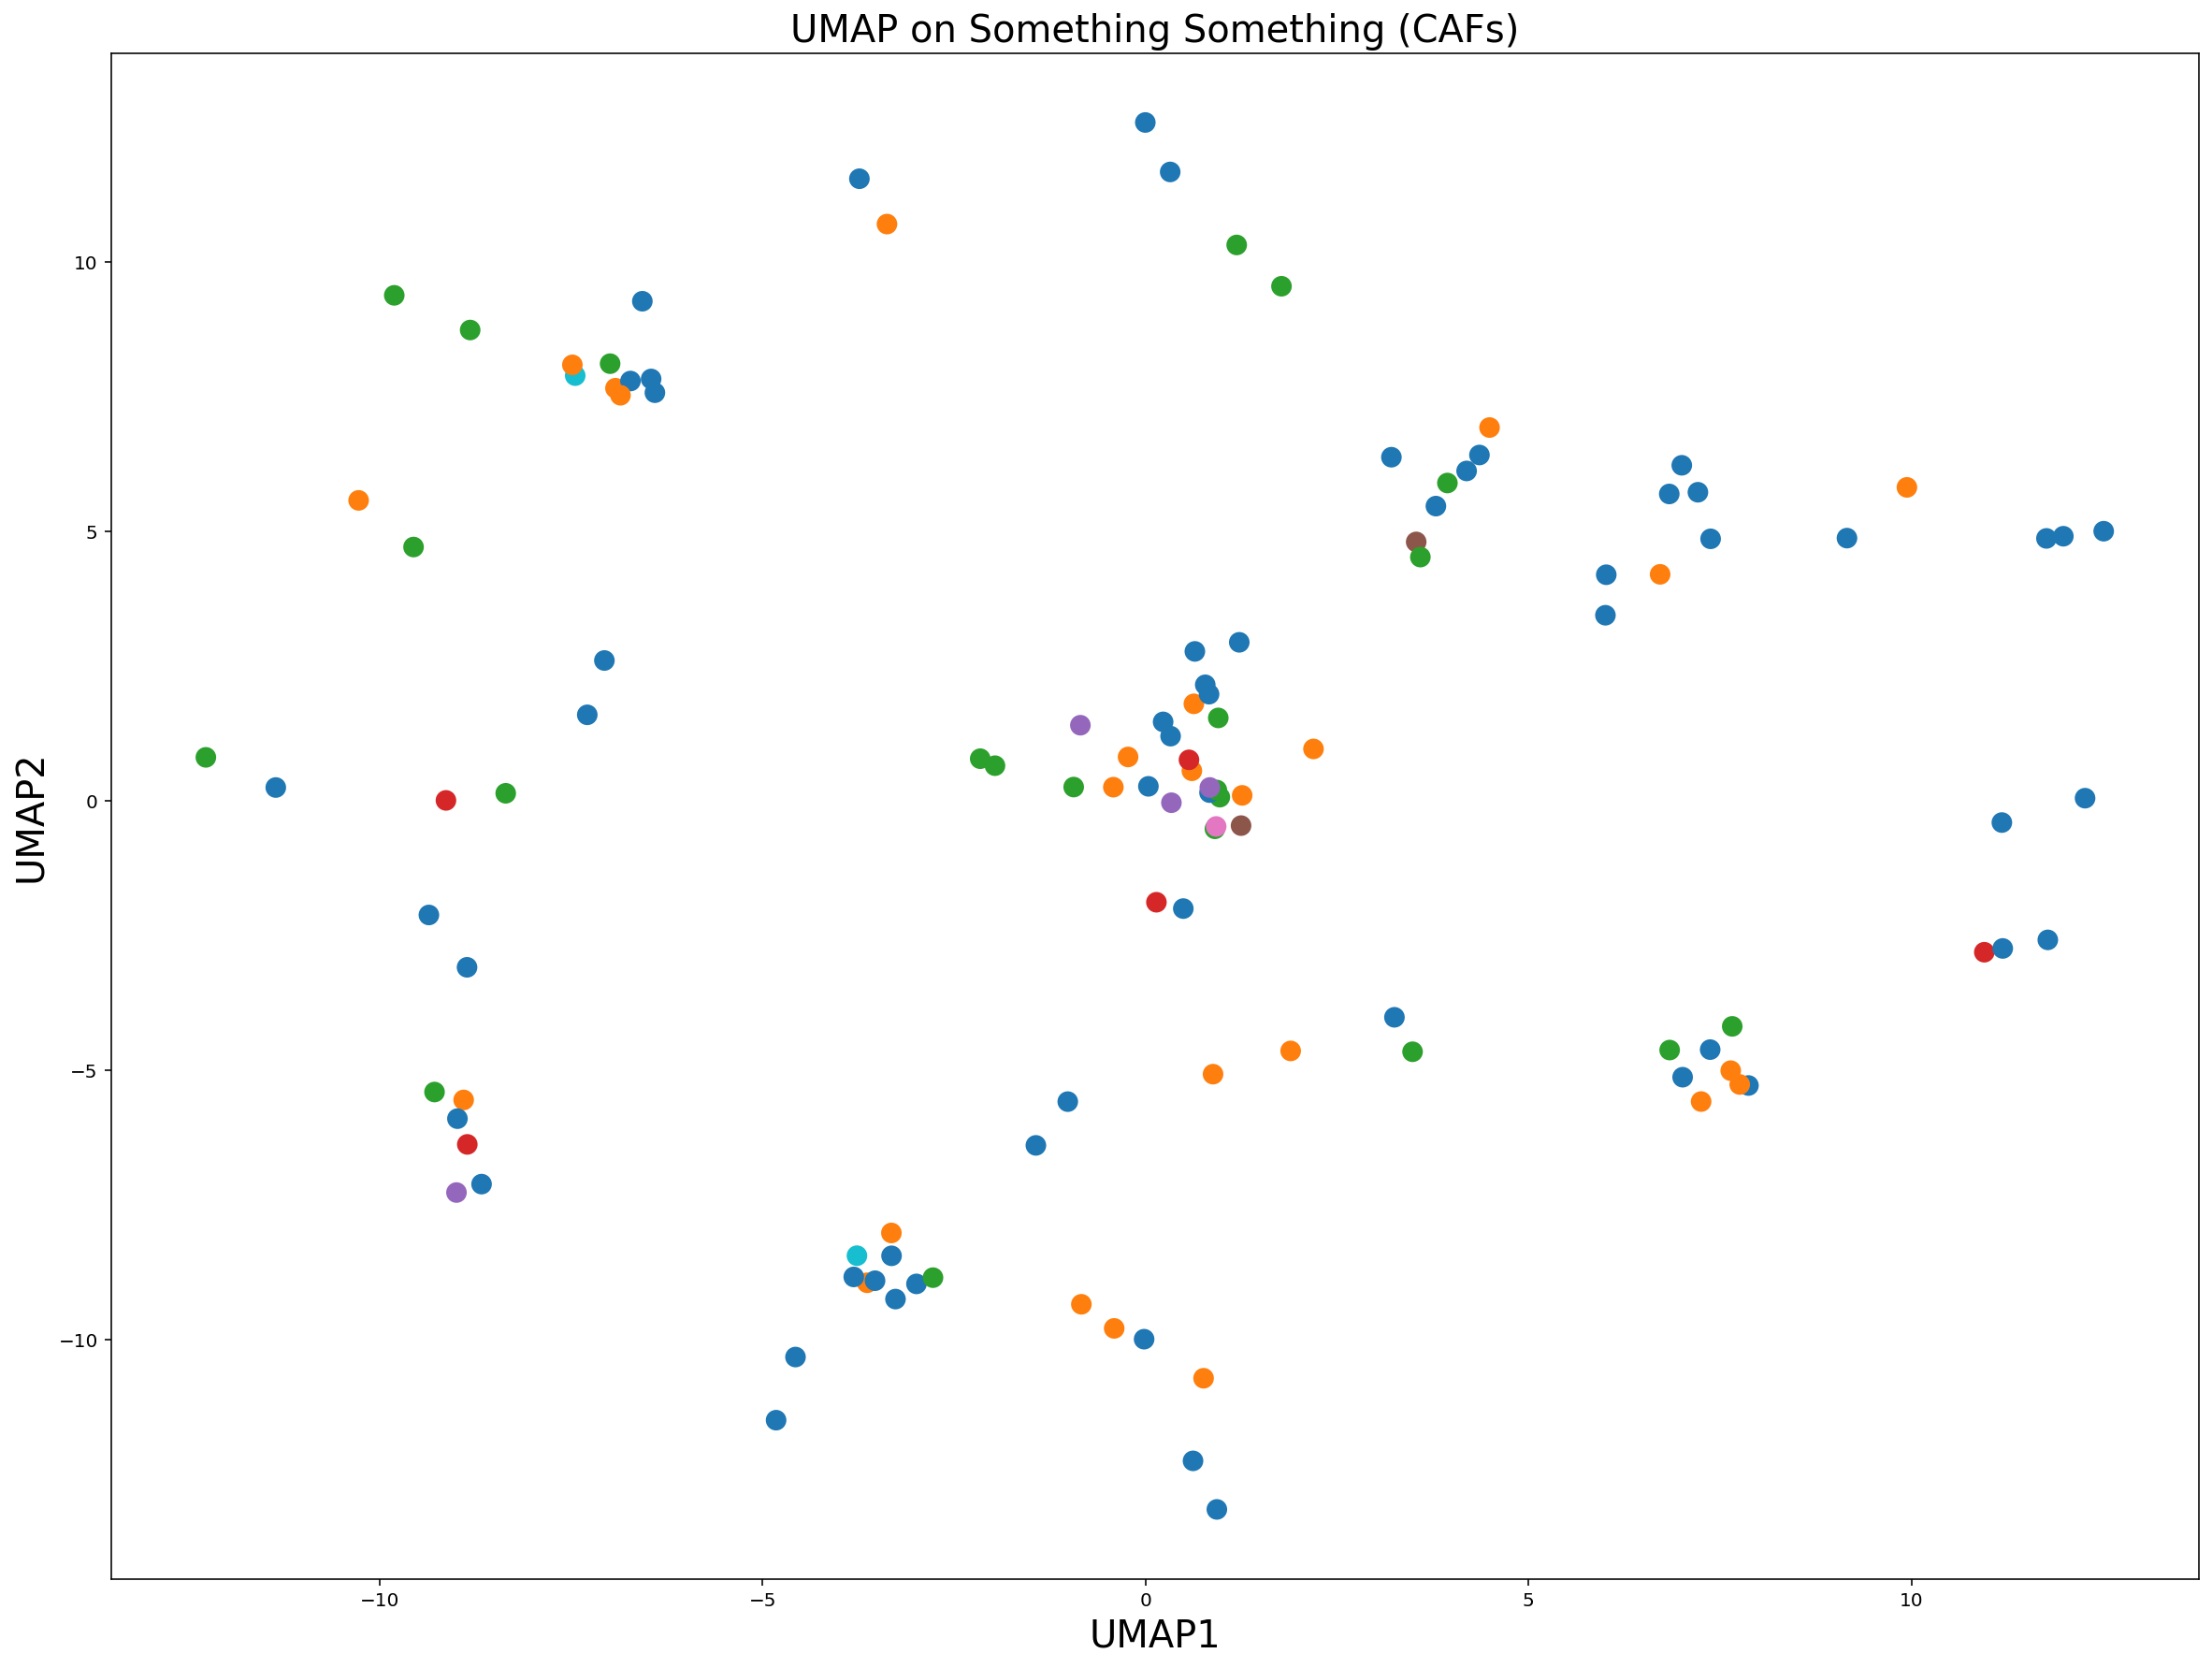

In [16]:
plt.figure(figsize=(20,15))
plt.scatter(y[:,0], y[:,1], c = y_train.astype(int), cmap = 'tab10', s = 100)
plt.title("UMAP on Something Something (CAFs)", fontsize = 20)
plt.xlabel("UMAP1", fontsize = 20); plt.ylabel("UMAP2", fontsize = 20)
plt.show()